# Prevendo indice da Ibovespa com modelo ARIMA

#### Autor: Rodrigo Araujo
https://www.linkedin.com/in/rodrigo-marcel-araujo-oliveira/

Nesse artigo vamos prever o indice do fechamento da Ibovespa. Nesse estudo vamos usar os dados com frequência mensal, onde cada valor é referente ao preço de fechamento do índice no último dia útil de cada mês.

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
%matplotlib inline
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt

In [2]:
# Download da série mensal do IBOVESPA
import quandl
data = quandl.get("BCB/7845", trim_start="2009-01-01")
data.head()

,Value
Date,
2009-01-31,39300.0
2009-02-28,38183.0
2009-03-31,40926.0
2009-04-30,47289.0
2009-05-31,53197.0


Seperando a base em treino e teste

In [5]:
data.columns = ['IBOVESPA']
meses = 5
treino = data.iloc[:-meses,0:1].copy()
teste = data.iloc[-meses:,0:1].copy()

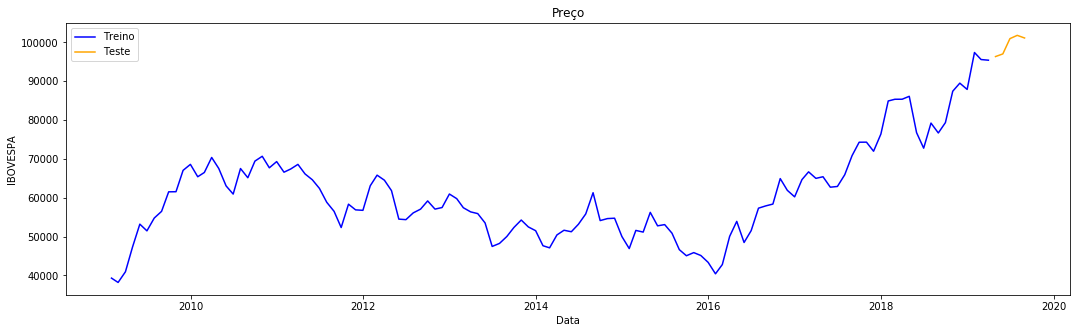

In [6]:
plt.figure(figsize=(18,5))
plt.title('Preço')
plt.plot(treino['IBOVESPA'], color='b')
plt.plot(teste['IBOVESPA'], color='orange')
plt.legend(['Treino','Teste'])
plt.xlabel('Data')
plt.ylabel('IBOVESPA')
plt.show()

A principio vamos estudar o comportamento da distribuição da serie entendendo seus pontos discriminantes, ou seja, maxima, minima, etc. Para isso vamos agrupar nossos dados com a finalidade de plotar esses dados. 

In [7]:
dt = treino.groupby('Date')["IBOVESPA"].mean().reset_index()
dt.head()

,Date,IBOVESPA
0,2009-01-31,39300.0
1,2009-02-28,38183.0
2,2009-03-31,40926.0
3,2009-04-30,47289.0
4,2009-05-31,53197.0


Text(0.5,0,'Mês')

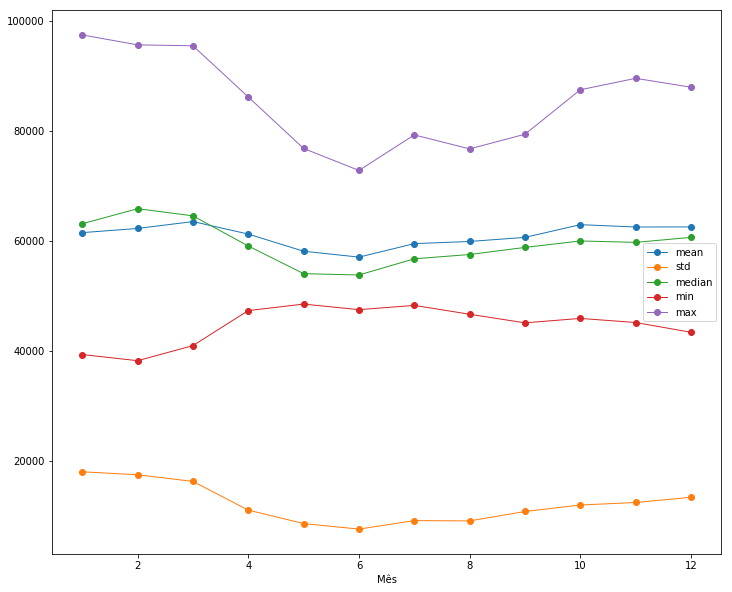

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10))
(dt.set_index('Date')
   .assign(month=lambda df: df.index.month)
   .groupby('month')['IBOVESPA'].agg(["mean", "std", "median", "min", "max"])
   .plot(ax=ax, marker="o",linewidth=1))
ax.set_xlabel('Mês')

É notável que há uma tendência nas medidas de métricas centrais. 

Para verificar se nossa série é estácionaria vamos transformar nossos dados em escala logaritma (como visto no artigo parte 2 de séries temporais). O logaritmo geralmente é usado para transformar séries que tem valores com crescimentos exponenciais em séries com crescimentos mais lineares, pois se trata de uma técnica de diferenciação. O cálculo dos log-retornos, fica mais simples se fizermos uma transformação na fórmula usando uma propriedade do logarítimo. 

In [9]:
# base de treino

ts_log_treino=np.log(treino["IBOVESPA"])
ts_log_dif_treino = ts_log_treino - ts_log_treino.shift()
ts_log_dif_treino.dropna(inplace=True)

Precisamos descobrir quantos parâmetros iremos utilizar na previsão. Como visto nos artigos anteriores, a série de retornos logaritma é uma série estacionária, sendo assim podemos analisar as funções de Autocorrelação (ACF) e Autocorrelação Parcial (PACF).

c:\anaconda\lib\site-packages\statsmodels\regression\linear_model.py:1283: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


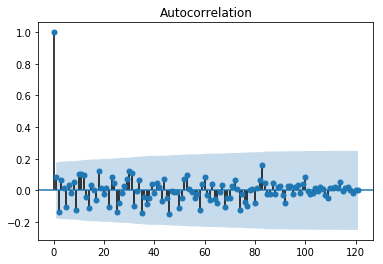

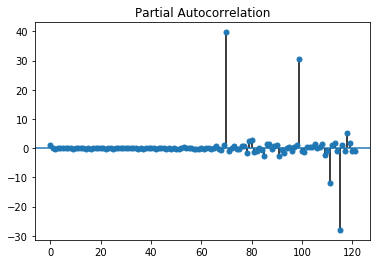

In [10]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts_log_dif_treino)
plot_pacf(ts_log_dif_treino)
plt.show()

In [11]:
from statsmodels.tsa.arima_model import ARIMA

In [18]:
## ARIMA
model = ARIMA(ts_log_treino,order=(10,1,3))
result_MA = model.fit(disp=0)
print(result_MA.summary())

c:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
c:\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
c:\anaconda\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                             ARIMA Model Results                              
Dep. Variable:             D.IBOVESPA   No. Observations:                  122
Model:                ARIMA(10, 1, 3)   Log Likelihood                 181.959
Method:                       css-mle   S.D. of innovations              0.053
Date:                Tue, 25 Feb 2020   AIC                           -333.918
Time:                        18:48:07   BIC                           -291.858
Sample:                    02-28-2009   HQIC                          -316.835
                         - 03-31-2019                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0070      0.005      1.350      0.180      -0.003       0.017
ar.L1.D.IBOVESPA      0.4901      0.162      3.028      0.003       0.173       0.807
ar.L2.D.IBOVESPA     -0.

O atributo summary() que resulta da saída de SARIMAX, retorna informações significativas, tais como Log Likelihood, AIC, etc. A coluna coef mostra o peso (importância) de cada recurso e como cada um deles afeta a série temporal. A coluna P>|z| nos informa a importância de cada peso, para cada um destes temos um valor p associado, o ideal é esse valor ser menor ou próximo a 0.05. <br>

Como podemos ver, os valores P dos termos MA são altamente significativos (<< 0,05). Enquanto os termos correspondente ao AR, nem todos são. Vamos considerar todos os coeficientes para nosso modelo, e avaliar os resultados. <br>

Abaixo temos os resultados correspondente ao periodo da base de teste, a partir de Março:

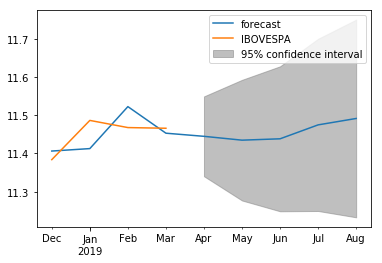

In [44]:
result_MA.plot_predict(start='2018-12-31', end='2019-08-31', plot_insample=True, alpha=0.05)
plt.show()

Podemos também aplicar o modelo para entender como será o indice da Ibovespa alguns meses há frente:

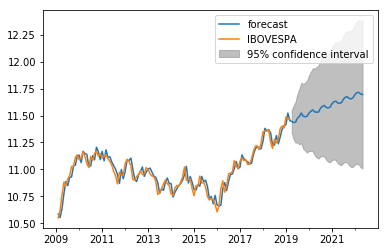

In [45]:
fig = result_MA.plot_predict(1 , 160)

In [56]:
result_MA.predict(122 ,160).head()

2019-03-31   -0.014725
2019-04-30   -0.021122
2019-05-31   -0.010059
2019-06-30    0.003577
2019-07-31    0.036446
Freq: M, dtype: float64

Ao ajustar modelos ARIMA, é importante diagnósticar os resultados para garantir que nenhuma das suposições feitas pelo modelo tenha sido violada

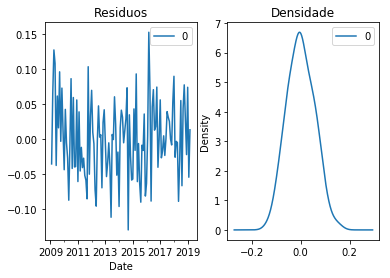

In [58]:
residuals = pd.DataFrame(result_MA.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuos", ax=ax[0])
residuals.plot(kind='kde', title='Densidade', ax=ax[1])
plt.show()

Nossa principal preocupação é garantir que os resíduos de nosso modelo não sejam correlacionados e normalmente distribuídos com média zero. Se o modelo ARIMA sazonal não atender a essas propriedades, é uma boa indicação de que pode ser melhorado ainda mais.

Nesse caso, nosso diagnóstico de modelo sugere que os resíduos do modelo são normalmente distribuídos com base no seguinte:

No gráfico ao lado direito, vemos que segue de perto da N(0,1), ou seja, distribuição normal com média 0 e desvio padrão de 1. Essa é uma boa indicação de que os resíduos são normalmente distribuídos. <br>

Os resíduos ao longo do tempo (gráfico ao lado esquerdo) não exibem nenhuma sazonalidade óbvia e parecem ser ruído branco. Isso é confirmado pelo gráfico de autocorrelação visto anteriormente, que mostra que os resíduos da série temporal têm baixa correlação com versões atrasadas de si mesmas. <br>

Essas observações nos levam a concluir que nosso modelo produz um ajuste satisfatório que pode nos ajudar a entender nossos dados de séries temporais e prever valores futuros. <br>

Embora tenhamos um ajuste satisfatório, alguns parâmetros de nosso modelo ARIMA sazonal podem ser alterados para melhorar nosso ajuste.

#### Referências: <br>

https://www.statsmodels.org/stable/index.html <br>
https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/ <br>
https://medium.com/@josemarcialportilla/using-python-and-auto-arima-to-forecast-seasonal-time-series-90877adff03c

#### Contato <br>

Se ficar com dúvidas não hesite em entrar em contato conosco. <br>
contato@tradingcomdados.com